# Librerias

In [31]:
from scipy.linalg import eigh
import numpy as np
import matplotlib.pyplot as plt

# Definicion de lattice y varios

In [32]:
# Definicion de lattice y bases fraccionales para hacer producto matricial y obtener coordenadas cartesianas
# (en unidades Å)
a = 3.8901956081
c = 23.7135486603
gamma = np.radians(120)
# Constantes de fuerza (en unidades eV/Å²)
force_constants = {
    "Si-Si": 5,
    "Si-H": 22,
    "2Si-H": 11
}

lattice = np.array([
    [ a, 0.0,  0.0],
    [ a * np.cos(gamma), a * np.sin(gamma) , 0.0],
    [ 0.0, 0.0,  c]
], dtype=float)

base_Si_frac = np.array([
    [2/3, 1/3, 16/33],
    [1/3, 2/3, 17/33]
], dtype=float)

base_H_frac = np.array([
    [2/3, 1/3, 0.4215227810],
    [1/3, 2/3, 0.5784772190]
], dtype=float)


mass = {
    "Si": 28.086,
    "H": 1.008
}

cell = np.concatenate([
    base_Si_frac,
    base_H_frac
]) @ lattice

# Definicion del orden de los atomos en la celda para asignar valores ij
order_i = ["Si", "Si", "H", "H"]
atom_n = len(order_i)
masses_i = np.array([mass[atom] for atom in order_i], dtype=float)
masses_ij = np.sqrt(np.tensordot(masses_i, masses_i, axes=0))
print(masses_ij)

[[28.086      28.086       5.32077889  5.32077889]
 [28.086      28.086       5.32077889  5.32077889]
 [ 5.32077889  5.32077889  1.008       1.008     ]
 [ 5.32077889  5.32077889  1.008       1.008     ]]


# Calculo de vectores $\hat{e}$

In [33]:
# Hallar los vectores e interactuantes y definir las constantes de fuerza
order_pairs = [
    ["Si-Si", "Si-Si", "Si-Si", "Si-H", "2Si-H", "2Si-H", "2Si-H"],
    ["Si-Si", "Si-Si", "Si-Si", "Si-H", "2Si-H", "2Si-H", "2Si-H"],
    ["Si-H", "2Si-H", "2Si-H", "2Si-H", 0, 0, 0],
    ["Si-H", "2Si-H", "2Si-H", "2Si-H", 0, 0, 0]
]

nested_force_cts = [
    [force_constants[atom_pair] if atom_pair != 0 else 0 for atom_pair in sublist]
    for sublist in order_pairs
]

# Convertir a un array de NumPy. Usar dtype=object permite sub-arrays de diferente longitud.
force_cts = np.array(nested_force_cts, dtype=float)

print(force_cts)

# vector final menos inicial para cada par de atomos interactuantes
R_01 = cell[1] - cell[0]
R_02 = cell[2] - cell[0]
R_03 = cell[3] - cell[0]
R_12 = cell[2] - cell[1]
R_13 = cell[3] - cell[1]

# Crear arrays para los vectores e, sus normales y los indices j
e = np.zeros((4, 7, 3), dtype=float)
e_norm = np.zeros((4, 7, 3), dtype=float)
e_jindex = np.zeros((4, 7), dtype=int)

e[0] = np.vstack([
    R_01 + lattice[0],
    R_01 - lattice[1],
    R_01,
    R_02,
    R_03 + lattice[0],
    R_03 - lattice[1],
    R_03
])

# Indices de los atomos con los que interactua el atomo 0 (Si)
e_jindex[0] = np.array([1, 1, 1, 2, 3, 3, 3])

# Normalizar cada vector fila
e_norm[0] = e[0] / np.linalg.norm(e[0], axis=1, keepdims=True)

# Repetir para el atomo 2 (Si)
e[1] = np.vstack([
    -R_01 + lattice[1],
    -R_01 - lattice[0],
    -R_01,
    R_13,
    R_12 + lattice[1],
    R_12 - lattice[0],
    R_12
])

e_jindex[1] = np.array([0, 0, 0, 3, 2, 2, 2])

# Normalizar cada vector fila
e_norm[1] = e[1] / np.linalg.norm(e[1], axis=1, keepdims=True)

e[2,0:4] = np.vstack([
    -R_02,
    -R_12 + lattice[0],
    -R_12 - lattice[1],
    -R_12
])

# Normalizar cada vector fila
e_norm[2,0:4] = e[2,0:4] / np.linalg.norm(e[2,0:4], axis=1, keepdims=True)

e_jindex[2,0:4] = np.array([0, 1, 1, 1])

e[3,0:4] = np.vstack([
    -R_13,
    -R_03 + lattice[1],
    -R_03 - lattice[0],
    -R_03
])

# Normalizar cada vector fila
e_norm[3,0:4] = e[3,0:4] / np.linalg.norm(e[3,0:4], axis=1, keepdims=True)

e_jindex[3,0:4] = np.array([1, 0, 0, 0])

[[ 5.  5.  5. 22. 11. 11. 11.]
 [ 5.  5.  5. 22. 11. 11. 11.]
 [22. 11. 11. 11.  0.  0.  0.]
 [22. 11. 11. 11.  0.  0.  0.]]


# Parametrizacion por el camino de alta simetria
Γ—M—K—Γ—A—L—H—L—M—K—Γ

In [34]:
# Definición de puntos de alta simetría (Kx, Ky, Kz)
# Puntos de alta simetria tomados de: https://seekpath.materialscloud.io/compute/process_structure/

G  = np.array([0.0,         0.0,         0.0        ])   # Gamma
M  = np.array([0.8075667576,0.4662488849,0.0        ])
K  = np.array([0.5383778384,0.9324977698,0.0        ])
A  = np.array([0.0,         0.0,         0.1324809162])
L  = np.array([0.8075667576,0.4662488849,0.1324809162])
H  = np.array([0.5383778384,0.9324977698,0.1324809162])
H2 = np.array([0.5383778384,0.9324977698,-0.1324809162])   # No usado, pero definido

# Camino de alta simetría que se va a recorrer
k_points = [G, M, K, G, A, L, H, L, M, K, G]

# Parametrización del camino
def parametrization_vec(k_points, n_points):
    path = []
    for i in range(len(k_points) - 1):
        start = k_points[i]
        end    = k_points[i + 1]
        paso  = np.linspace(start, end, n_points, endpoint=False)
        path.extend(paso)
    path.append(k_points[-1])
    return np.array(path)

n_points_segment = 100
k_path = parametrization_vec(k_points, n_points_segment)

# Obtencion de la matriz dinamica y $\omega(K)$

In [35]:
# Definir la matriz dinamica D(k)
def dynamic_matrix(k, cell, e, e_norm, e_jindex, force_cts, masses_ij):
    N = cell.shape[0]
    D = np.zeros((3*N, 3*N), dtype=complex)

    for i in range(N):
        for l in range(7):  # Numero maximo de interacciones por atomo
            kappa = force_cts[i, l]
            if kappa == 0:
                continue

            j = e_jindex[i, l]
            e_vec = e_norm[i, l]
            R_vec = e[i, l]

            phase = np.exp(1j * np.dot(k, R_vec))

            # Construir D_ij (3x3)
            matrix_ij = -kappa * np.outer(e_vec, e_vec)
            D[i*3:(i+1)*3, j*3:(j+1)*3] += matrix_ij * phase  / masses_ij[i, j]
            D[i*3:(i+1)*3, i*3:(i+1)*3] += -matrix_ij / masses_ij[i, i]

    D = (D + D.conj().T) / 2  # Asegurar que es hermitica
    return D



# Calcular frecuencias para cada k del camino
n_k = len(k_path)
n_modes = 3 * atom_n
frequencies = np.zeros((n_k, n_modes))

for position, k_vec in enumerate(k_path):

    # Matriz dinamica para este k
    D_k = dynamic_matrix(k_vec, cell, e, e_norm, e_jindex, force_cts, masses_ij)

    # Autovalores (omega^2)
    w2, _ = eigh(D_k)
    w2 = np.real(w2)

    # Calculo de omega unicamente con los valores reales
    w = np.zeros_like(w2)
    mascara = w2 >= 0
    w[mascara] = np.sqrt(w2[mascara])

    frequencies[position] = w


# Ordenar los modos
frequencies.sort(axis=1)

print(frequencies[0])

for i in range(3):
    if any (frequencies[:, i] > 1e-2):
        print(f"La funcion {i} es distinta a cero (máyor en algún punto a 1e-2)")

[0.00000000e+00 1.13701262e-08 4.98074148e-08 6.83175932e-01
 6.83175932e-01 1.19663511e+00 2.92847563e+00 2.92847563e+00
 2.93150492e+00 2.93150492e+00 6.16742040e+00 6.27453775e+00]
La funcion 1 es distinta a cero (máyor en algún punto a 1e-2)
La funcion 2 es distinta a cero (máyor en algún punto a 1e-2)


# Grafica de dispersion

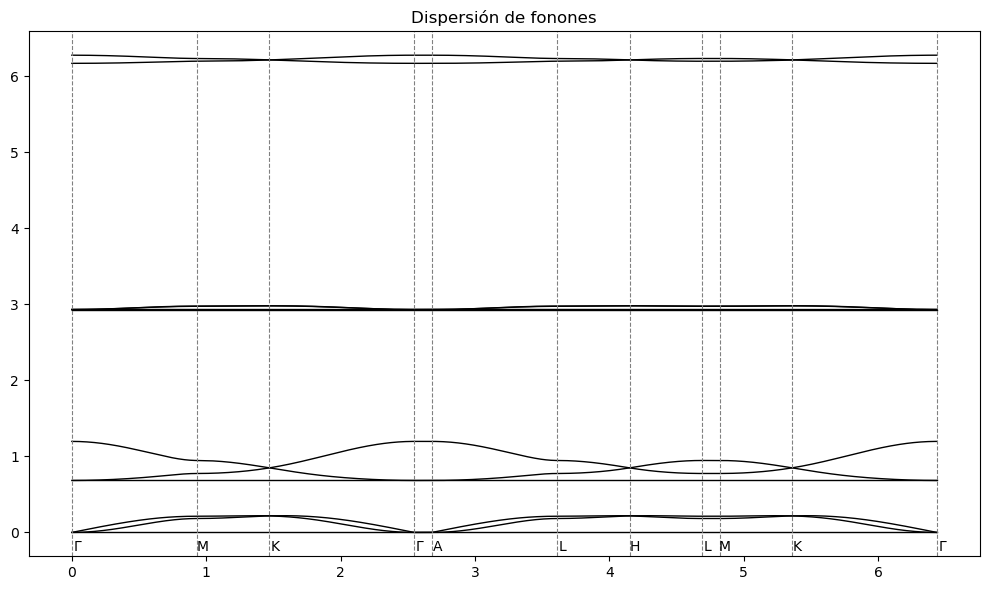

In [46]:
# Cálculo de la norma de k para graficar en función de la distancia en el espacio recíproco
dK = np.linalg.norm( np.diff(k_path, axis=0), axis=1 )
K_norm = np.concatenate(([0], np.cumsum(dK)))

# Grafico de dispersion de fonones, no tengo ni la mas remota idea de usar matplotlib, se lo pedi a chatgpt
labels = ["Γ","M","K","Γ","A","L","H","L","M","K","Γ"]
plt.figure(figsize=(10,6))
for modo in range(n_modes):
    plt.plot(K_norm, frequencies[:, modo], 'k-', linewidth=1)


for i in range(len(labels)):
    plt.axvline(K_norm[n_points_segment * i], color='gray', linestyle='--', linewidth=0.8)
    plt.text(K_norm[n_points_segment * i]+0.04, -0.1, labels[i], ha='center', va='top')
# plt.ylim( 2.8, 3.0)
plt.title("Dispersión de fonones")
plt.tight_layout()
plt.show()  